## Pythonによる画像解析実例 #2: 対象の形態と輝度の計測
サンプル画像「dots.tif」中の蛍光ドットの蛍光強度を計測
file:///Users/masak_takaine/Dropbox/ImageJ_programming/230126_ImageJ_luncheon_MT/comment2.html

In [15]:
import numpy as np
import scipy as sp
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, img_as_float, img_as_ubyte
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image
from tifffile import tifffile as tiff
from skimage.segmentation import clear_border
from skimage import data, util
from skimage.measure import label, regionprops_table
import PySimpleGUI as sg

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

dots.tifには顕微鏡のメタデータも含まれているのでライブラリtifffileで開く

In [16]:
img = tiff.imread("images/dots.tif")
mask = img.copy()
print("読み込まれた画像の枚数:", len(img))
print("配列の次元数:", img.ndim)
print("配列の形状:", img.shape)
print("要素のデータ型:", img.dtype)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


読み込まれた画像の枚数: 349
配列の次元数: 2
配列の形状: (349, 436)
要素のデータ型: uint8


In [17]:
with tiff.TiffFile("images/dots.tif") as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:",f.filename)
    print("各次元の説明:", f.series[0].axes)
    tags = f.pages[0].tags
    ijmetadata = f.imagej_metadata

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


ファイル名: dots.tif
各次元の説明: YX


In [18]:
# Voxel sizeとResolutionはimagej_metadataとtagsの情報から計算できる
# 複数のZスライスが含まれる場合はZResolutionも考慮に入れる
lengthunit = ijmetadata["unit"]
xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
print("Unit of length:", lengthunit)
print(f"Resolution in X: {xresolution} pixels per {lengthunit}")
print(f"Resolution in Y: {yresolution} pixels per {lengthunit}")
print(f"Voxel size: {1/xresolution} x {1/yresolution} x 1 {lengthunit}^3")

Unit of length: micron
Resolution in X: 11.361111 pixels per micron
Resolution in Y: 11.361111 pixels per micron
Voxel size: 0.0880195607630275 x 0.0880195607630275 x 1 micron^3


### ドットの分節化  
maskの方でドットを分節化する。輝度の閾値を画像全体の平均+3×標準偏差 に設定したいので、まず基本統計量を計算。閾値thrを設定する。

平均値: 15.288366499303383
最大値: 255
最小値: 0
分散: 419.8220851605969
標準偏差: 20.48956039451791


(array([1.05759e+05, 3.49100e+04, 4.70200e+03, 1.95900e+03, 1.22600e+03,
        7.65000e+02, 6.03000e+02, 3.85000e+02, 3.19000e+02, 2.45000e+02,
        2.15000e+02, 1.45000e+02, 1.35000e+02, 1.13000e+02, 9.90000e+01,
        8.10000e+01, 8.30000e+01, 7.30000e+01, 4.50000e+01, 3.02000e+02]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

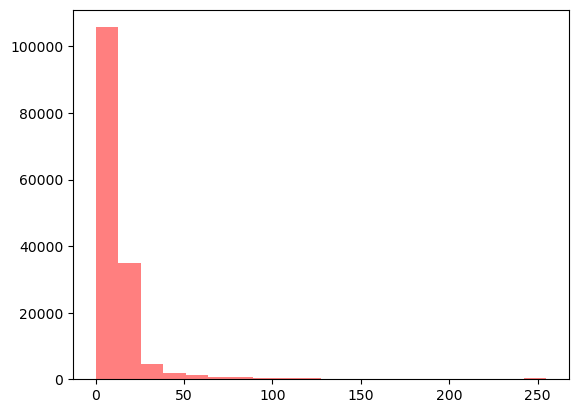

In [19]:
print("平均値:", img.mean())
print("最大値:", img.max())
print("最小値:", img.min())
print("分散:", img.var())
print("標準偏差:", img.std())
thr = img.mean() + 3*img.std() # 2値化の閾値を設定
plt.hist(img.ravel(), bins = 20, range = [0, img.max()], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

<class 'numpy.ndarray'>
(21668,)


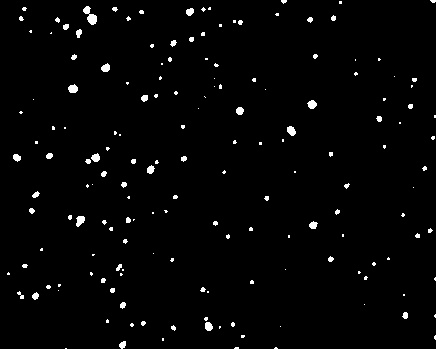

In [20]:
# 2値画像の作成
ret, mask_bin = cv2.threshold(mask, thr, 255, cv2.THRESH_BINARY)
show(mask_bin)

<class 'numpy.ndarray'>
(20701,)


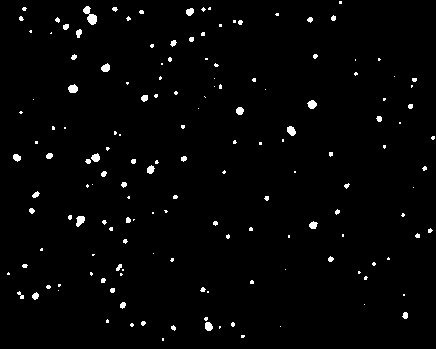

In [21]:
# いくつかの対象が画面の端(border)と接しているのでこれらを除く
mask_bin = clear_border(mask_bin)
show(mask_bin)

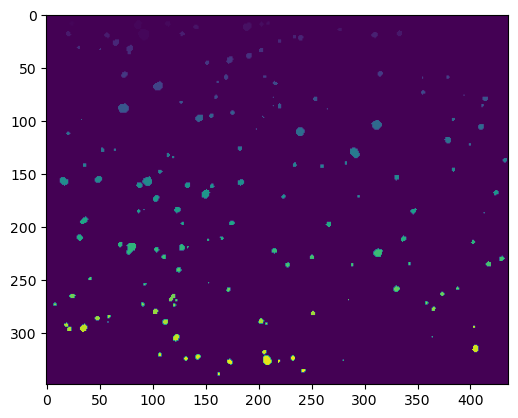

In [22]:
# 重なっている対象がほとんど無いので、そのままラベリング
# もし重なっている対象が多い場合はwatershed等で分割を試みる
ret, markers, stats, centroids = cv2.connectedComponentsWithStats(mask_bin)
plt.imshow(markers)

In [23]:
# 蛍光強度の測定、intensity_imgのオリジナルのimgを指定
# 今回は実際の画像"Image_intensity"は計測項目に入れない
prop_dic = regionprops_table(markers, intensity_image = img, properties=["label", "area", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"])
data = pd.DataFrame(prop_dic)

In [24]:
data.shape

(155, 9)

In [25]:
# areaはpixel数で表されているので、area_pixにrename
# さらに長さの単位であるµm^2に変換したAreaを追加
data["Area"] = data.area * (1/xresolution)**2
data = data.rename({"area": "area_pix"}, axis = 1)

In [26]:
# 0.04 =<Area =< 500のデータを抽出する
data= data[(data.Area >= 0.04) & (data.Area <= 500)]

In [27]:
# data["Circularity"] = (4*np.pi * data.area_pix)/data.perimeter/data.perimeter  # なぜかCirc. > 1となる
data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
data["Roundness"] = 1/data.aspect_ratio
data["IntDen"] = data.Area * data.intensity_mean # Integrated Density, µm^2ベース
data["RawIntDen"] = data.area_pix * data.intensity_mean # Integrated Density, pixel ベース

# データを解析した日付とファイル名を表す変数を追加
date = "2023-08-01"
path ="images/dots.tif"
filename = os.path.basename(path)
data["Date"] = date
data["File"] = filename

In [28]:
data.shape

(126, 16)

In [29]:
# 列の並べ替え
data = data.iloc[:, [0, 14, 15, 9,1,2,12,13,3,4,5,6,7,8,10,11]]

In [30]:
# インデックスを振り直す, 古いindexが変数"index"となるので削除
data = data.reset_index(drop=True)
data.head(20)

,label,Date,File,Area,area_pix,intensity_mean,IntDen,RawIntDen,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,aspect_ratio,Roundness
0,1,2023-08-01,dots.tif,0.069727,9,94.777778,6.608569,853.0,125.0,3.265986,3.265986,8.000000,1.000000,3.605551,1.000000,1.000000
1,2,2023-08-01,dots.tif,0.116212,15,121.800000,14.154579,1827.0,181.0,4.618802,4.061746,11.656854,0.937500,5.099020,1.137147,0.879394
2,3,2023-08-01,dots.tif,1.014915,131,162.496183,164.919821,21287.0,255.0,22.498347,9.209083,54.870058,0.770588,20.615528,2.443060,0.409323
3,4,2023-08-01,dots.tif,0.154949,20,140.450000,21.762568,2809.0,221.0,5.614956,4.555466,14.485281,0.909091,6.082763,1.232575,0.811309
4,5,2023-08-01,dots.tif,0.100717,13,120.923077,12.178981,1572.0,176.0,4.150996,4.150996,11.313708,1.000000,5.000000,1.000000,1.000000
5,6,2023-08-01,dots.tif,0.061980,8,85.875000,5.322493,687.0,96.0,3.464102,2.738613,7.414214,1.000000,3.605551,1.264911,0.790569
6,7,2023-08-01,dots.tif,0.379625,49,169.285714,64.265040,8295.0,254.0,8.844347,7.092999,23.313708,0.980000,8.944272,1.246912,0.801981
7,8,2023-08-01,dots.tif,0.131707,17,120.294118,15.843521,2045.0,175.0,5.181900,4.041201,12.242641,1.000000,5.385165,1.282267,0.779869
8,9,2023-08-01,dots.tif,0.077474,10,100.400000,7.778433,1004.0,124.0,3.919184,3.098387,8.828427,1.000000,4.123106,1.264911,0.790569
9,10,2023-08-01,dots.tif,0.178191,23,139.391304,24.838303,3206.0,253.0,5.733826,5.037514,15.071068,0.958333,6.324555,1.138225,0.878561


In [31]:
data.to_csv("dots_results.csv")

In [32]:
# ナンバリング画像を作る関数
# dataに残っている、0.04 < Area < 500のラベルについてのみ番号を振る
labels = data.label# dataからlabelを抽出
def numbering2(img_segm, stats, labels):
    numbered_img = img_segm.copy()
    for label in labels:
        x, y, width, height, area = stats[label] 
        cv2.putText(numbered_img, f"{label}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    return numbered_img

<class 'numpy.ndarray'>
(48280,)


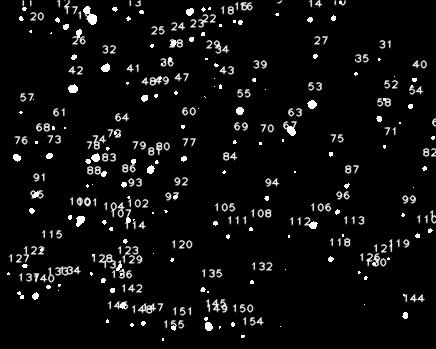

True

In [34]:
img_numbered = numbering2(mask_bin, stats, labels)
show(img_numbered)
cv2.imwrite("dots_numbered.png", img_numbered)

#### バッチ処理化
上記の画像処理を、フォルダ内の複数の画像ファイルに対して適用できるようマクロを修正。  
各ファイルに対して測定結果のcsvファイルを保存する

In [2]:
# データフレーム作成までを関数化,inputはfile path, date
def analyze_particles(path, date):
    img = tiff.imread(path)
    mask = img.copy()
    with tiff.TiffFile("images/dots.tif") as f: # with構文でファイルを開くと様々なメタデータが抽出できる
        tags = f.pages[0].tags
        ijmetadata = f.imagej_metadata
    lengthunit = ijmetadata["unit"]
    xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
    yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
    thr = img.mean() + 3*img.std() # 2値化の閾値を設定
    ret, mask_bin = cv2.threshold(mask, thr, 255, cv2.THRESH_BINARY)
    mask_bin = clear_border(mask_bin)
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(mask_bin)
    
    prop_list = ["label", "area", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"]
    prop_dic = regionprops_table(markers, intensity_image = img, properties= prop_list)
    data = pd.DataFrame(prop_dic)
    data["Area"] = data.area * (1/xresolution)**2
    data = data.rename({"area": "area_pix"}, axis = 1)
    data= data[(data.Area >= 0.04) & (data.Area <= 500)]
    data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
    data["Roundness"] = 1/data.aspect_ratio
    data["IntDen"] = data.Area * data.intensity_mean # Integrated Density, µm^2ベース
    data["RawIntDen"] = data.area_pix * data.intensity_mean # Integrated Density, pixel ベース
    basename = os.path.basename(path)
    data["Date"] = date
    data["File"] = basename
    data = data.iloc[:, [0,14,15,9,1,2,12,13,3,4,5,6,7,8,10,11]]
    data = data.reset_index(drop=True)
    
    return mask_bin, markers, stats, data, xresolution, yresolution, ijmetadata,basename

In [3]:
def numbering2(img_segm, stats, labels):
    numbered_img = img_segm.copy()
    for label in labels:
        x, y, width, height, area = stats[label] 
        cv2.putText(numbered_img, f"{label}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
    return numbered_img

In [32]:
# 確認
# Main code
date = "2023-08-01"
path ="images/dots.tif"
mask_bin, markers, stats, data, xres, yres, ijmeta, basename = analyze_particles(path, date)
labels = data.label# dataからlabelを抽出
numbered_img = numbering2(mask_bin, stats, labels)
filename = basename.split(".")[0]
csv_savepath = filename + "_results.csv"
numbered_savepath = filename + "_numbered.tif"
data.to_csv(csv_savepath)
tiff.imwrite(numbered_savepath, numbered_img,
     imagej = True,
     resolution = (xres, yres),
     metadata = ijmeta)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [26]:
# バッチ処理化
# source folder内のファイルリストを取得して順番に処理、拡張子の無いファイル名、測定結果のデータフレーム、ナンバリングした2値化画像、resolutionのタプル、メタデータをそれぞれリストに格納
# 処理が終わったら、folderDの下のcsvとsegmented_imagesにそれぞれcsvファイルと2値化した画像を保存
folderS = "/Users/masak_takaine/Dropbox/MT_Python/images/for_batch_processing"
folderD = "/Users/masak_takaine/Dropbox/MT_Python/images/batch_results"
date = "2023-08-10"
file_list = glob.glob(folderS + "/*") #フォルダ内の全てのfile/folderのリストを取得して、ソートしておく
file_list.sort(reverse=True) 

# 各ファイルの解析結果を格納するリスト
fname_list = []
df_list = []
img_list = []
reso_list = []
metadata_list =[]

csv_folder = os.path.join(folderD, "csv")
if not os.path.exists(csv_folder):  #dirが存在しなければ作成する
    os.mkdir(csv_folder)  

numbered_folder = os.path.join(folderD, "segmented_images")    
if not os.path.exists(numbered_folder):  
    os.mkdir(numbered_folder) 

for path in file_list:
    if ".tif" in path:
        mask_bin, markers, stats, data, xres, yres, ijmeta, basename = analyze_particles(path, date)
        labels = data.label# dataからlabelを抽出
        numbered_img = numbering2(mask_bin, stats, labels)    
        filename = basename.split(".")[0]
        fname_list.append(filename)
        df_list.append(data)
        img_list.append(numbered_img)
        reso_list.append((xres, yres))
        metadata_list.append(ijmeta)
        
for filename, data, img, reso, meta in zip(fname_list, df_list, img_list, reso_list, metadata_list):
    csv_savepath = os.path.join(csv_folder, filename + "_results.csv")
    data.to_csv(csv_savepath)
    numbered_savepath = os.path.join(numbered_folder, filename + "_numbered.tif")
    tiff.imwrite(numbered_savepath, img, imagej = True, resolution = reso, metadata = meta)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

#### さらに、読み込むファイルの入ったフォルダ（source folder）と保存先のフォルダ（destination folder）をGUIで指定できるようにする

In [4]:
layout = [
    [sg.Text("Date of experiments:"), sg.InputText(key="date",default_text = "test")],
   [sg.Text("Source folder:"), sg.InputText(key="folderS")],[sg.FolderBrowse(target="folderS", initial_folder= os.getcwd())],
    [sg.Text("Destination folder:"), sg.InputText(key="folderD")],[sg.FolderBrowse(target="folderD", initial_folder= os.getcwd())],
          [sg.Submit(), sg.Cancel()],
]

window = sg.Window("Choose folders", layout)
while True:
    event, values = window.read()
    if event in (sg.WIN_CLOSED, 'Cancel'):
        break
    # elif event == 'Submit':
    else:
        date = values["date"]
        folderS = values["folderS"]
        folderD = values["folderD"]
        file_list = glob.glob(folderS + "/*") #フォルダ内の全てのfile/folderのリストを取得して、ソートしておく
        file_list.sort() 

        # 各ファイルの解析結果を格納するリスト
        fname_list = []
        df_list = []
        img_list = []
        reso_list = []
        metadata_list =[]

        csv_folder = os.path.join(folderD, "csv")
        if not os.path.exists(csv_folder):  #dirが存在しなければ作成する
            os.mkdir(csv_folder)  

        numbered_folder = os.path.join(folderD, "segmented_images")    
        if not os.path.exists(numbered_folder):  
            os.mkdir(numbered_folder) 

        for path in file_list:
            if ".tif" in path:
                mask_bin, markers, stats, data, xres, yres, ijmeta, basename = analyze_particles(path, date)
                labels = data.label# dataからlabelを抽出
                numbered_img = numbering2(mask_bin, stats, labels)    
                filename = basename.split(".")[0]
                fname_list.append(filename)
                df_list.append(data)
                img_list.append(numbered_img)
                reso_list.append((xres, yres))
                metadata_list.append(ijmeta)

        for filename, data, img, reso, meta in zip(fname_list, df_list, img_list, reso_list, metadata_list):
            csv_savepath = os.path.join(csv_folder, filename + "_results.csv")
            data.to_csv(csv_savepath)
            numbered_savepath = os.path.join(numbered_folder, filename + "_numbered.tif")
            tiff.imwrite(numbered_savepath, img, imagej = True, resolution = reso, metadata = meta)
        print("Done.")
        break
        
window.close()

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

Done.


In [5]:
df_list[0]

,label,Date,File,Area,area_pix,intensity_mean,IntDen,RawIntDen,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,aspect_ratio,Roundness
0,1,test,dots_image_1.tif,0.108464,14,85.000000,9.219457,1190.0,107.0,4.615856,4.000000,11.899495,0.933333,5.099020,1.153964,0.866578
1,3,test,dots_image_1.tif,0.092969,12,84.583333,7.863655,1015.0,102.0,3.829708,3.829708,9.656854,1.000000,4.123106,1.000000,1.000000
2,4,test,dots_image_1.tif,0.116212,15,91.333333,10.613997,1370.0,120.0,4.618802,4.061746,11.656854,0.937500,5.099020,1.137147,0.879394
3,5,test,dots_image_1.tif,0.170444,22,104.500000,17.811372,2299.0,141.0,5.565537,4.972652,14.485281,1.000000,6.082763,1.119229,0.893472
4,8,test,dots_image_1.tif,0.054232,7,74.714286,4.051913,523.0,77.0,3.703280,2.138090,6.828427,1.000000,3.605551,1.732051,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,1565,test,dots_image_1.tif,0.100717,13,86.153846,8.677136,1120.0,105.0,4.318667,3.679465,10.242641,1.000000,4.472136,1.173722,0.851991
1229,1566,test,dots_image_1.tif,0.178191,23,96.173913,17.137344,2212.0,130.0,5.733826,5.037514,15.071068,0.958333,6.324555,1.138225,0.878561
1230,1568,test,dots_image_1.tif,0.061980,8,78.125000,4.842152,625.0,89.0,3.464102,2.738613,7.414214,1.000000,3.605551,1.264911,0.790569
1231,1569,test,dots_image_1.tif,0.100717,13,78.846154,7.941129,1025.0,91.0,4.748377,3.559754,11.071068,1.000000,5.099020,1.333906,0.749678
